# Generating audios with Azure TTS (Speech-To-Text)
1. COG_SERVICE_KEY and COG_SERVICE_REGION are the key and region for the Azure service.
2. voicName, pitch, speakingRate are the name of the virtual speaker, the pitch level and the speaing rate respectively.These variables can be modified.
3. Please replace the text with your list of sentences
4. You do not need to generate the datasets (the third cell) if you already have your speech data

In [1]:
import azure.cognitiveservices.speech as speech_sdk
import json

In [2]:
# specify the Azure service key and the service region
COG_SERVICE_KEY="Your service key"
COG_SERVICE_REGION="Your service region"

def text_to_speech(text, save_file, languageCode='en-US', voicName='en-US-JennyNeural', speakingRate="0%", pitch = '0%', voiceStyle = 'chat'):
    # process the voice name, pitch, and speaking rate into a format taht Apzure can recognize
    head1 = f'<speak xmlns="http://www.w3.org/2001/10/synthesis" xmlns:mstts="http://www.w3.org/2001/mstts" xmlns:emo="http://www.w3.org/2009/10/emotionml" version="1.0" xml:lang="{languageCode}">'
    head2 = f'<voice name="{voicName}">'
    head3 =f'<mstts:express-as style="{voiceStyle}">'
    head4 = f'<prosody rate="{speakingRate}" pitch="{pitch}">'
    tail= '</prosody></mstts:express-as></voice></speak>'
    ssml = head1 + head2 + head3 + head4 + text + tail
   
    # set up speech configurations
    speech_config = speech_sdk.SpeechConfig(subscription=COG_SERVICE_KEY, region=COG_SERVICE_REGION)
    audio_config = speech_sdk.audio.AudioOutputConfig(filename=save_file) # specify the path to save audio
    speech_synthesizer = speech_sdk.SpeechSynthesizer(speech_config=speech_config, audio_config=audio_config)

    # synthesize the speech audio
    speech_synthesis_result = speech_synthesizer.speak_ssml_async(ssml).get()

In [3]:
# specify audio characteristics
voicName= 'en-US-JennyNeural' # specify the speaker
pitch = '0%' # specify the pitch level (height of speech)
speakingRate='0%' # specify the peaking rate (speaking speed)
path_to_txt= {}
texts = ["reliable", "it's an interesting examination"] # pleaes replace this variable with a list of your sentences
for tp_sentence in texts:
    path = "_audios/"+tp_sentence+".wav"  # specify the path to save for the current audio
    path_to_txt[path] = tp_sentence  # save the sentence for each audio path
    # synthesize the speech audio
    text_to_speech(tp_sentence, path, voicName=voicName, pitch=pitch, speakingRate=speakingRate)

# Getting timestamps for each syllable and nucleus with Azure PA
This section applies the Azure pronunciation assessment service to get the timestamps for syllable and nucleus.
Readers may use their own speech data by modifying the variable "path_to_txt". It is a dictionary where the key is the path of the file and the value is the sentence spoken.

In [4]:
# Pronunciation assessment for audio sentences
def pronunciation_assessment(tp_word_sentence, audio_file):
    # Configurate the pronunciation assessment module
    pronunciation_assessment_config_dict = {
                                        "referenceText": tp_word_sentence,# sentence string
                                        "gradingSystem": "HundredMark", # rate system
                                        "granularity": "Phoneme", # granularity of rating
                                        "EnableMiscue": True
                                        }


    # Pronunciation assessment
    pronunciation_assessment_config_json = json.dumps(pronunciation_assessment_config_dict)
    pronunciation_assessment_config = speech_sdk.PronunciationAssessmentConfig(json_string=pronunciation_assessment_config_json)
    speech_recognizer = speech_sdk.SpeechRecognizer(speech_config, audio_config)
    pronunciation_assessment_config.apply_to(speech_recognizer)
    result = speech_recognizer.recognize_once() # result is the return of the API in string format

    js_re = json.loads(result.json) # convert the string format to Json
    return js_re 

In [5]:
re_bindex = {} # Save the Azure Pronunciation Assessment returns here
speech_config = speech_sdk.SpeechConfig(subscription=COG_SERVICE_KEY, region=COG_SERVICE_REGION)
for audio_file in path_to_txt: # 'Paths' is a list of paths to the audio files
    audio_config = speech_sdk.AudioConfig(filename=audio_file)
    
    # 'path_to_txt' is from the code in Subsection 3.1.2 
    # It is a dictionary where the key is the file path and the value is the sentence for the audio
    tp_word_sentence = path_to_txt[audio_file] 

    re_bindex[audio_file] = pronunciation_assessment(tp_word_sentence, audio_file) # add the result into the dictionary

# Visualization of pitch level and intensity
This part is just used for visualization.
The second cell was not used when processing the training and testing datasets

In [6]:
import parselmouth
import matplotlib.pyplot as plt
import numpy as np

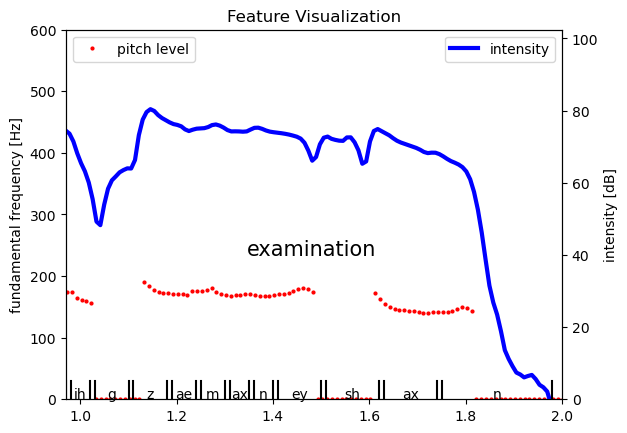

In [7]:
# this cell was not used when processing training and testing datasets.
def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='blue', label="intensity")
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")
    plt.legend(loc=0)
    
def draw_pitch(pitch):
    # Extract selected pitch contour
    pitch_values = pitch.selected_array['frequency']
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2, color='red', label="pitch level")
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")
    plt.legend(loc=2)

audio_file = list(path_to_txt.keys())[1]  # the path of your audio file
word_sentence = path_to_txt[audio_file]  # the sentence spoken in the audio
sound = parselmouth.Sound(audio_file)

pitch = sound.to_pitch()
draw_pitch(pitch)
intensity = sound.to_intensity()
plt.twinx()
draw_intensity(intensity)
plt.xlim([0.97, 2]) # the range of x to show
plt.xlabel("Time (s)")

# annotate words with results from the Azure Pronunciatn Assessment API
pro_re = pronunciation_assessment(word_sentence, audio_file)
words = pro_re["NBest"][0]["Words"]
for i in range(len(words)):
    tp_phos = words[i]['Phonemes']
    for j in range(len(tp_phos)):
        tp_pho = tp_phos[j]
        start = tp_pho['Offset']*1e-7
        duration = tp_pho['Duration']*1e-7
        plt.annotate(tp_pho["Phoneme"], (start+duration/2, 0.3), fontsize=10, ha="center")
        plt.plot([start, start], [0.3, 5], color="black")
        plt.plot([start+duration, start+duration], [0.3, 5], color="black")
        
# annotate words
for i in range(len(pro_re["NBest"][0]["Words"])):
    if 'Offset' in pro_re["NBest"][0]["Words"][i]:
        start = pro_re["NBest"][0]["Words"][i]['Offset']*1e-7
        duration = pro_re["NBest"][0]["Words"][i]['Duration']*1e-7
        plt.annotate(pro_re["NBest"][0]["Words"][i]["Word"], (start+duration/2, 40), fontsize=15, ha="center")
    
plt.title("Feature Visualization")
plt.show()

# Extracting numerical and categorical features
In this section, twelve numerical features and one categorical feature will be extracted for each syllable.
This section incldues three parts:
1. Reading the pronunciation dictionary
2. Calcualtion of weights for stress levels for each type of syllable
3. Extraction and  normalization of features

In [8]:
# read the pronunciation dictionary and save them in word_to_phone
f_dict = open("pronunciation dictionary/cmudict-0.7b.txt")
lines = f_dict.readlines()
f_dict.close()

# conver data into a dict
word_to_phone= {}
for line in lines:
    line=line.strip('\n').lower()
    tp_data = line.split('  ')
    tp_word = tp_data[0]
    tp_phones = tp_data[1].strip().split(" ")
    if tp_word.isalpha():
        word_to_phone[tp_word] = []
        for tp_pho in tp_phones:
            if tp_pho[-1].isdigit():
                word_to_phone[tp_word].append((tp_pho[:-1], int(tp_pho[-1])))
            else:
                word_to_phone[tp_word].append((tp_pho, -1))

In [9]:
# calculate the weights of stress levels for each type of syllable.
# the resutls are stored in the variable "weights"
import math
Azure_vowels = {"iy", "ih", "ey", "eh", "ae", "aa", "ao", "uh", "ow", "uw", "ah", "ay", "aw", "oy", "ax", "er"}

# get the vowels
vowels_bw = [] # vowels for each word [word, [vowel 1, vowel 2, ...]]
for audio_file in re_bindex:
    tp_words = re_bindex[audio_file]["NBest"][0]["Words"]
    for tp_word in tp_words:
        tp_ph_count = 0 # index of the current phoneme
        tp_ph_num = len(tp_word["Phonemes"])
        if "Syllables" in tp_word:
            tp_word_vowels = []
            for tp_syl in tp_word["Syllables"]:
                tp_syl_al = tp_syl["Syllable"] # current syllable string
                tp_pho_string = "" # current syllale string formed from phonemes
                for tp_ct in range(tp_ph_count, tp_ph_num):
                    tp_pho_txt = tp_word["Phonemes"][tp_ct]["Phoneme"]
                    tp_pho_string += tp_pho_txt
                    if tp_pho_txt in Azure_vowels:
                        tp_word_vowels.append(tp_pho_txt)

                    if tp_pho_string == tp_syl_al:
                        tp_ph_count = tp_ct + 1
                        break
            
            vowels_bw.append([tp_word["Word"], tp_word_vowels])
            
stress_bw = {tp_vo:{i:0 for i in [0,1,2]} for tp_vo in Azure_vowels}
for tp_index in range(len(vowels_bw)):
    tp_word = vowels_bw[tp_index][0]
    tp_vos = vowels_bw[tp_index][1]
    # get the length and stress of each vowel
    if tp_word in word_to_phone:
        tp_phs = word_to_phone[tp_word]
        tp_stress = [tp_p[1] for tp_p in tp_phs if tp_p[1] != -1]
        if len(tp_stress) == len(tp_vos) and len(tp_stress)>1:
            for i in range(len(tp_stress)):
                tp_sl = 0
                if tp_stress[i] == 1:
                    tp_sl=2
                if tp_stress[i] == 2:
                    tp_sl=1
                stress_bw[tp_vos[i]][tp_sl] += 1
                
# weights per syllable type
weights = {tp_vo:{i:0 for i in [0,1,2]} for tp_vo in Azure_vowels}
for tp_vo in stress_bw:
    tp_nums = stress_bw[tp_vo]
    if sum(tp_nums.values())>0:
        ps = [tp_nums[i]/sum(tp_nums.values()) for i in range(3)]
        tp_w = {}
        tp_pmax = max(ps)
        for i in range(3):
            if ps[i]>0:
                tp_w[i] = math.pow(tp_pmax/ps[i], 0.7)

        weights[tp_vo] = tp_w

In [10]:
# thefunction is used to get numerical features for syllables
def get_features(start, duration, xs, pi_y, int_xs, in_y):
    """
    start is the start time of the syllable
    duration is the duration of the syllable
    xs is a list of timestamps for pitches
    pi_y is the pitch-level
    int_xs is a list of timestamps for intensity
    in_y is the intensity
    """
    pitch_index = np.logical_and(xs>=start, xs<=start+duration)
    tp_pi_data = pi_y[pitch_index][np.where(pi_y[pitch_index]!=0)]
    tp_pi_data = tp_pi_data if len(tp_pi_data)>0 else np.array([0.0])
    inten_inex = np.logical_and(int_xs>=start, int_xs<=start+duration)
    tp_in_data = in_y[inten_inex]
    syl_pitch_max = tp_pi_data.max()
    syl_pitch_ave = tp_pi_data.mean()
    syl_inten_max = tp_in_data.max()
    syl_inten_ave = tp_in_data.mean()
    syl_durat_nor = duration
    syl_pitch_len = len(tp_pi_data)
    tp_syl_X = [syl_pitch_max, syl_pitch_ave, syl_pitch_len, syl_inten_max, syl_inten_ave, syl_durat_nor]
    return tp_syl_X

In [11]:
X_sentence = [] # attributes of each syllable
Y_sentence = [] # stress level of each syllable
W_sentence = [] # weights for each syllable
for audio_file in re_bindex:
# for tp_index in re_bindex:
#     audio_file = "_data/sentence audio from Azure/en-US-"+tp_file_name+"_"+str(tp_index)+".wav"
    if re_bindex[audio_file]['RecognitionStatus']=='Success':
        words = re_bindex[audio_file]["NBest"][0]["Words"]
        if "Syllables" in words[0]:
            tp_sentence_x = []
            tp_sentence_y = []
            tp_sentence_w = []
            
            sound = parselmouth.Sound(audio_file)
            pitch = sound.to_pitch()
            intensity = sound.to_intensity()
            xs = pitch.xs()
            int_xs = intensity.xs()
            pi_y = pitch.selected_array['frequency']
            in_y = intensity.values[0]
            
            for j in range(len(words)): # j is the index of word
                tp_word_x = []
                tp_word_y = []
                tp_word_w = []
                tp_word = words[j]
                if "Syllables" in tp_word:
                    tp_syls = tp_word['Syllables']
                    tp_ph_count = 0 # index of the current phoneme
                    tp_ph_num = len(tp_word["Phonemes"])
                    if tp_word["Word"] in word_to_phone: # if the current word is in the dictionary
                        tp_dict_phos = word_to_phone[tp_word["Word"]]
                        # get the expected pitch
                        tp_pis = [] # standard stress for each syllable
                        for tp_pho_d in tp_dict_phos:
                            if tp_pho_d[1] != -1:
                                if tp_pho_d[1]==2:
                                    tp_pis.append(1)
                                elif tp_pho_d[1]==1:
                                    tp_pis.append(2)
                                else:
                                    tp_pis.append(0)

                        if len(tp_pis) == len(tp_syls) and len(tp_syls)>1:
                            for k in range(len(tp_pis)): # k is the index of syllable
                                tp_syl = tp_syls[k]

                                start = tp_syl['Offset']*1e-7
                                duration = tp_syl['Duration']*1e-7
                                tp_syl_X = get_features(start, duration, xs, pi_y, int_xs, in_y)

                                # get the nuclei start, duration, and type
                                tp_syl_al = tp_syl["Syllable"]
                                tp_vowels = [] # vowels of the current syllable
                                tp_pho_string = "" # current syllale string formed from phonemes
                                for tp_ct in range(tp_ph_count, tp_ph_num):
                                    tp_pho = tp_word["Phonemes"][tp_ct]
                                    tp_pho_txt = tp_pho["Phoneme"]
                                    tp_pho_string += tp_pho_txt
                                    if tp_pho_txt in Azure_vowels:
                                        tp_vowels.append(tp_pho_txt)
                                        nuclei_start = tp_pho["Offset"]*1e-7
                                        nuclei_duration = tp_pho["Duration"]*1e-7

                                    if tp_pho_string == tp_syl_al:
                                        tp_ph_count = tp_ct + 1
                                        break

                                tp_syl_X_nuclei = get_features(start, duration, xs, pi_y, int_xs, in_y)
                                if len(tp_vowels) != 1:
                                    print("error: length of vowel is not one")
                                nuclei_type = tp_vowels[0]

                                tp_syllable_x = []
                                tp_syllable_x.extend(tp_syl_X)
                                tp_syllable_x.extend(tp_syl_X_nuclei)
                                tp_syllable_x.append(nuclei_type)
                                tp_syllable_w=weights[nuclei_type][tp_pis[k]]

                                tp_word_x.append(tp_syllable_x)
                                tp_word_y.append(tp_pis[k])
                                tp_word_w.append(tp_syllable_w)

                    if len(tp_word_x)>0:
                        tp_sentence_x.append(tp_word_x)
                        tp_sentence_y.append(tp_word_y)
                        tp_sentence_w.append(tp_word_w)
                    
            if len(tp_sentence_x)>0:
                X_sentence.append(tp_sentence_x)
                Y_sentence.append(tp_sentence_y)
                W_sentence.append(tp_sentence_w)

# Save data
save data to the local device using the "pickle" module

In [12]:
# save data
import pickle as pkl
f = open("data for training and testing/test.pkl", 'wb')
pkl.dump((X_sentence, Y_sentence, W_sentence) ,f)
f.close()